<a href="https://colab.research.google.com/github/KhayalM/Coursera-WebDev-JHU-Assignments/blob/master/Extended_Finite_Element_Methods_mycode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mesh Creation and Loading

In [ ]:
for name in dir():
    if not name.startswith('_'):
        del globals()[name]

# You can also use a magic command for a clean restart (clears all variables and re-runs cells above)
# %reset -f

print("All user-defined variables deleted.")

All user-defined variables deleted.


In [ ]:
try:
    import google.colab  # noqa: F401
except ImportError:
    import gmsh
else:
    try:
        import gmsh
    except ImportError:
        !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
        import gmsh

In [ ]:
import gmsh

# Initialize Gmsh
gmsh.initialize()

# Create a new model
gmsh.model.add("I_beam")

# Characteristic length for the mesh
lc = 0.05 # Adjust for finer or coarser mesh

# ------------------------------
# Define points for the I-shape
# ------------------------------
gmsh.model.geo.addPoint(0, 0, 0, lc, 1)   # Bottom-left corner
gmsh.model.geo.addPoint(1, 0, 0, lc, 2)   # Bottom-right corner
gmsh.model.geo.addPoint(1, 0.2, 0, lc, 3) # Inner corner (bottom right)
gmsh.model.geo.addPoint(0.8, 0.2, 0, lc, 4)# Inner corner (bottom left)
gmsh.model.geo.addPoint(0.8, 0.8, 0, lc, 5)# Inner corner (top right)
gmsh.model.geo.addPoint(1, 0.8, 0, lc, 6) # Inner corner (top right outer)
gmsh.model.geo.addPoint(1, 1, 0, lc, 7)   # Top-right corner
gmsh.model.geo.addPoint(0, 1, 0, lc, 8)   # Top-left corner
gmsh.model.geo.addPoint(0, 0.8, 0, lc, 9) # Inner corner (top left)
gmsh.model.geo.addPoint(0.2, 0.8, 0, lc, 10)# Inner corner (top left inner)
gmsh.model.geo.addPoint(0.2, 0.2, 0, lc, 11)# Inner cut bottom left
gmsh.model.geo.addPoint(0, 0.2, 0, lc, 12)# Inner cut bottom left outer

# ------------------------------
# Define lines for the I-shape
# ------------------------------
gmsh.model.geo.addLine(1, 2, 1)
gmsh.model.geo.addLine(2, 3, 2)
gmsh.model.geo.addLine(3, 4, 3)
gmsh.model.geo.addLine(4, 5, 4)
gmsh.model.geo.addLine(5, 6, 5)
gmsh.model.geo.addLine(6, 7, 6)
gmsh.model.geo.addLine(7, 8, 7)
gmsh.model.geo.addLine(8, 9, 8)
gmsh.model.geo.addLine(9, 10, 9)
gmsh.model.geo.addLine(10, 11, 10)
gmsh.model.geo.addLine(11, 12, 11)
gmsh.model.geo.addLine(12, 1, 12)

# ------------------------------
# Create curve loop and plane surface
# ------------------------------
curve_loop = gmsh.model.geo.addCurveLoop([1,2,3,4,5,6,7,8,9,10,11,12])
I_surface = gmsh.model.geo.addPlaneSurface([curve_loop])

# Synchronize CAD kernel
gmsh.model.geo.synchronize()

# ------------------------------
# Physical group for FEM
# ------------------------------
gmsh.model.addPhysicalGroup(2, [I_surface], 1)
gmsh.model.setPhysicalName(2, 1, "I_Beam")

# ------------------------------
# Mesh generation
# ------------------------------
gmsh.option.setNumber("Mesh.ElementOrder", 1)  # First-order triangles
gmsh.option.setNumber("Mesh.Algorithm", 6)    # Delaunay

gmsh.model.mesh.generate(2)

# Save mesh
gmsh.write("I_beam.msh")

# Optional: show mesh
# gmsh.fltk.run()

# Finalize
gmsh.finalize()


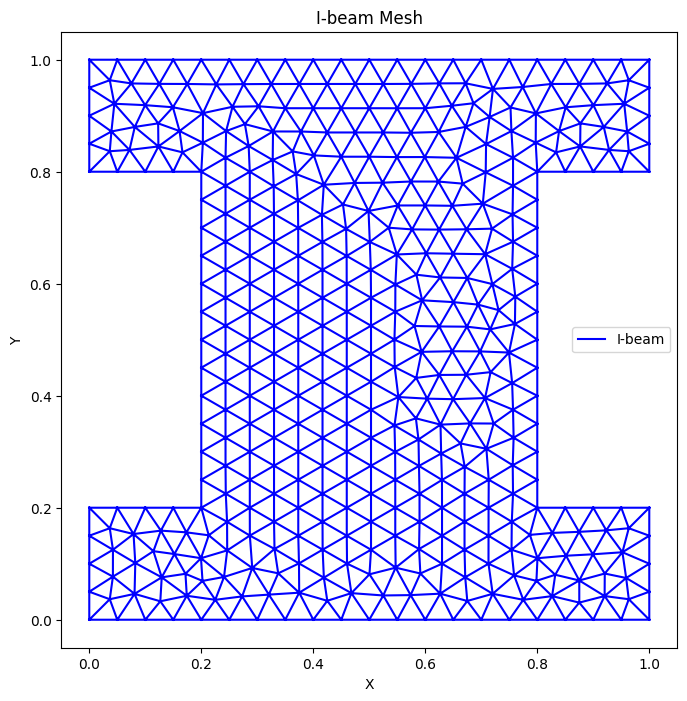

In [ ]:
import gmsh
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Initialize Gmsh and load the I-beam mesh
# ------------------------------
gmsh.initialize()
gmsh.open("I_beam.msh")

# Get all nodes
node_tags, node_coords, _ = gmsh.model.mesh.getNodes()
node_coords = np.array(node_coords).reshape(-1, 3)

# ------------------------------
# Function to get elements of a physical group
# ------------------------------
def get_elements_of_physical_group(dim, tag):
    entity_tags = gmsh.model.getEntitiesForPhysicalGroup(dim, tag)
    all_elements = []
    for entity_tag in entity_tags:
        element_types, element_tags, node_tags_list = gmsh.model.mesh.getElements(dim, entity_tag)
        for i in range(len(element_types)):
            all_elements.append(np.array(node_tags_list[i]).reshape(-1, 3))
    return np.concatenate(all_elements) if all_elements else np.array([])

# ------------------------------
# Get elements for the I-beam (physical group 1)
# ------------------------------
elements_I_beam = get_elements_of_physical_group(2, 1)

# ------------------------------
# Plot the mesh
# ------------------------------
plt.figure(figsize=(8, 8))

if elements_I_beam.size > 0:
    plt.triplot(node_coords[:, 0], node_coords[:, 1], elements_I_beam - 1, color='blue', label='I-beam')

plt.gca().set_aspect('equal')
plt.title('I-beam Mesh')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

# ------------------------------
# Finalize Gmsh
# ------------------------------
gmsh.finalize()


In [ ]:
import gmsh
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Load I-beam mesh from Gmsh
# ------------------------------
gmsh.initialize()
gmsh.open("I_beam.msh")

# Get nodes
node_tags, node_coords, _ = gmsh.model.mesh.getNodes()
node_coords = np.array(node_coords).reshape(-1, 3)
num_nodes = node_coords.shape[0]

# Function to get elements of a physical group
def get_elements_of_physical_group(dim, tag):
    entity_tags = gmsh.model.getEntitiesForPhysicalGroup(dim, tag)
    all_elements = []
    for entity_tag in entity_tags:
        element_types, element_tags, node_tags_list = gmsh.model.mesh.getElements(dim, entity_tag)
        for i in range(len(element_types)):
            # Only take linear triangles (element_type 2)
            if element_types[i] == 2:
                all_elements.append(np.array(node_tags_list[i]).reshape(-1, 3))
    return np.concatenate(all_elements) if all_elements else np.array([])

# Get I-beam elements
elements = get_elements_of_physical_group(2, 1) - 1  # subtract 1 to convert to 0-based indexing
num_elements = elements.shape[0]

gmsh.finalize()


# Linear Elastic Finite Element Code

In [ ]:
E = 210e9       # Young's modulus (Pa)
nu = 0.3        # Poisson's ratio

# Plane stress elasticity matrix
D = (E / (1 - nu**2)) * np.array([
    [1, nu, 0],
    [nu, 1, 0],
    [0, 0, (1 - nu) / 2]
])

In [ ]:
ndof = 2 * num_nodes  # 2 DOFs per node
K = np.zeros((ndof, ndof))
F = np.zeros(ndof)

# Loop over elements
for el in elements:
    node_ids = el
    x = node_coords[node_ids, 0]
    y = node_coords[node_ids, 1]

    # Compute area of triangle
    A = 0.5 * np.linalg.det(np.array([[1, x[0], y[0]],
                                      [1, x[1], y[1]],
                                      [1, x[2], y[2]]]))

    # B matrix for linear triangle
    b = np.array([y[1]-y[2], y[2]-y[0], y[0]-y[1]])
    c = np.array([x[2]-x[1], x[0]-x[2], x[1]-x[0]])
    B = np.zeros((3, 6))
    B[0, [0,2,4]] = b
    B[1, [1,3,5]] = c
    B[2, [0,2,4]] = c
    B[2, [1,3,5]] = b
    B /= (2*A)

    # Element stiffness
    Ke = A * (B.T @ D @ B)

    # Assemble into global K
    dof = np.array([2*node_ids[0], 2*node_ids[0]+1,
                    2*node_ids[1], 2*node_ids[1]+1,
                    2*node_ids[2], 2*node_ids[2]+1])
    for i in range(6):
        for j in range(6):
            K[dof[i], dof[j]] += Ke[i,j]


In [ ]:
# ------------------------------
# Apply boundary conditions
# ------------------------------
# Fix nodes at bottom edge (y=0)
fixed_nodes = np.where(node_coords[:,1] == 0)[0]
fixed_dofs = []
for n in fixed_nodes:
    fixed_dofs.append(2*n)      # x DOF
    fixed_dofs.append(2*n + 1)  # y DOF

free_dofs = np.setdiff1d(np.arange(ndof), fixed_dofs)

In [ ]:
# ------------------------------
# Apply loads
# ------------------------------
# Apply vertical force at top edge (y=1)
top_nodes = np.where(node_coords[:,1] == 1)[0]
F_load = -1e5  # N per node, downward
for n in top_nodes:
    F[2*n+1] += F_load  # y-direction

In [ ]:
U = np.zeros(ndof)
U[free_dofs] = np.linalg.solve(K[np.ix_(free_dofs, free_dofs)],
                               F[free_dofs])


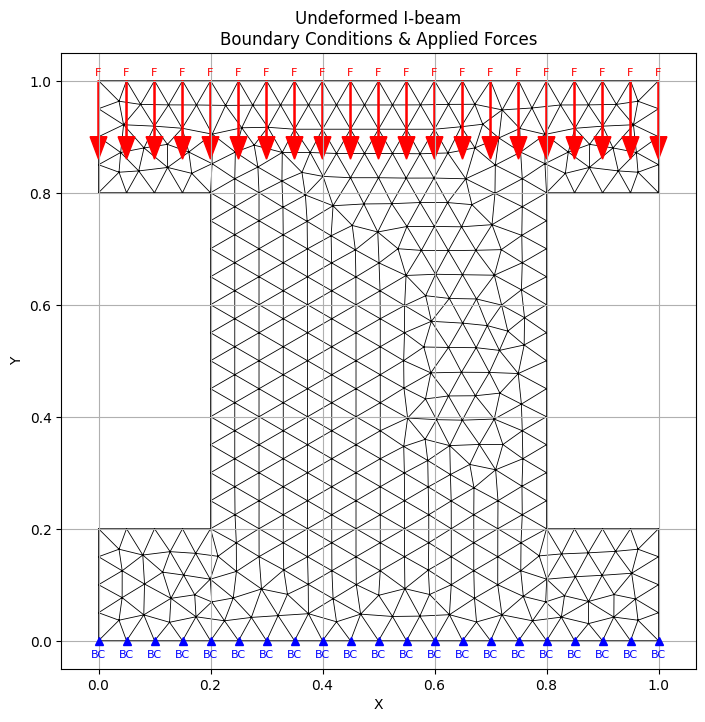

In [ ]:
# ---------------------------------------
# VISUALIZATION: Undeformed shape + BC + Loads
# ---------------------------------------

plt.figure(figsize=(10, 8))

# --- Plot mesh ---
plt.triplot(node_coords[:, 0], node_coords[:, 1], elements, color='black', linewidth=0.6)
plt.gca().set_aspect('equal')

# -------------------------------------------------------
# --- Plot boundary conditions (bottom edge fixed nodes)
# -------------------------------------------------------
for n in fixed_nodes:
    x, y = node_coords[n, 0], node_coords[n, 1]
    plt.plot(x, y, '^', color='blue', markersize=6)  # blue triangles
    plt.text(x, y - 0.03, 'BC', color='blue', fontsize=8, ha='center')

# -------------------------------------------------------
# --- Plot applied loads (top edge)
# -------------------------------------------------------
arrow_scale = 0.10 * (node_coords[:,1].max() - node_coords[:,1].min())

for n in top_nodes:
    x, y = node_coords[n, 0], node_coords[n, 1]
    plt.arrow(
        x, y,                     # start
        0, -arrow_scale,          # dx, dy (vertical downward)
        width=0.002,
        head_width=0.03,
        head_length=0.04,
        color='red'
    )
    plt.text(x, y + 0.01, 'F', color='red', fontsize=8, ha='center')

# -------------------------------------------------------
# Final plot formatting
# -------------------------------------------------------
plt.title("Undeformed I-beam\nBoundary Conditions & Applied Forces")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()

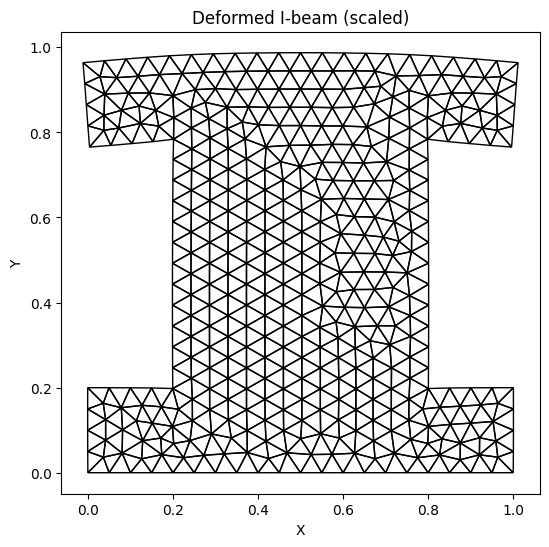

In [ ]:
scale = 1e3  # scale factor for visualization
plt.figure(figsize=(8,6))
for el in elements:
    x = node_coords[el, 0]
    y = node_coords[el, 1]
    xd = x + scale*U[2*el]
    yd = y + scale*U[2*el+1]
    plt.fill(xd, yd, edgecolor='k', fill=False)

plt.gca().set_aspect('equal')
plt.title('Deformed I-beam (scaled)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


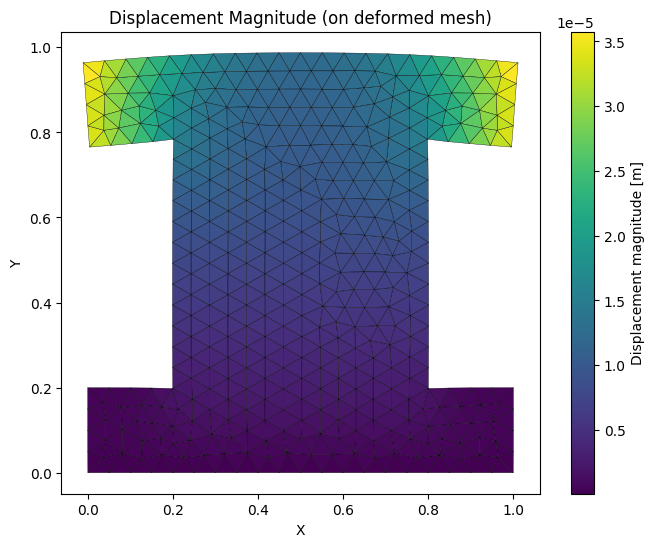

In [ ]:
# ------------------------------------------------------------
# Plot displacement magnitude on deformed shape
# ------------------------------------------------------------
U_mag = np.sqrt(U[0::2]**2 + U[1::2]**2)    # magnitude at each node

# Calculate average displacement magnitude per element for coloring
U_mag_elements = np.array([np.mean(U_mag[el]) for el in elements])

# deformed coordinates
x_def = node_coords[:,0] + scale * U[0::2]
y_def = node_coords[:,1] + scale * U[1::2]

plt.figure(figsize=(8,6))

tpc = plt.tripcolor(
    x_def, y_def, elements,
    facecolors=U_mag_elements, # Changed to U_mag_elements
    cmap='viridis',
    #shading='gouraud',   # smooth coloring
    edgecolors='k'
)

plt.colorbar(tpc, label='Displacement magnitude [m]')
plt.gca().set_aspect('equal')
plt.title('Displacement Magnitude (on deformed mesh)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [ ]:
# ------------------------------------------------------------
# Compute stresses and Von Mises stress for each element
# ------------------------------------------------------------
von_mises = []

for el in elements:
    node_ids = el
    x = node_coords[node_ids, 0]
    y = node_coords[node_ids, 1]

    # Triangle area
    A = 0.5 * np.linalg.det(np.array([[1, x[0], y[0]],
                                      [1, x[1], y[1]],
                                      [1, x[2], y[2]]]))

    b = np.array([y[1]-y[2], y[2]-y[0], y[0]-y[1]])
    c = np.array([x[2]-x[1], x[0]-x[2], x[1]-x[0]])
    B = np.zeros((3, 6))
    B[0, [0,2,4]] = b
    B[1, [1,3,5]] = c
    B[2, [0,2,4]] = c
    B[2, [1,3,5]] = b
    B /= (2*A)

    # Element DOFs
    dof = np.array([
        2*node_ids[0], 2*node_ids[0]+1,
        2*node_ids[1], 2*node_ids[1]+1,
        2*node_ids[2], 2*node_ids[2]+1
    ])

    # Element displacement vector
    Ue = U[dof]

    # Stresses (σx, σy, τxy)
    stress = D @ (B @ Ue)

    # Von Mises for plane stress
    sx, sy, txy = stress
    vm = np.sqrt(sx**2 - sx*sy + sy**2 + 3*txy**2)

    von_mises.append(vm)

von_mises = np.array(von_mises)

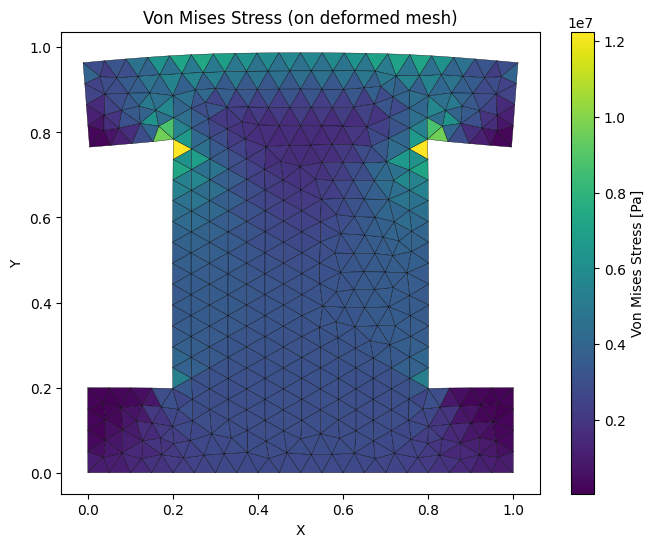

In [ ]:
# ------------------------------------------------------------
# Von Mises plot on deformed mesh
# ------------------------------------------------------------
plt.figure(figsize=(8, 6))

tpc2 = plt.tripcolor(
    x_def, y_def, elements,
    facecolors=von_mises,
    cmap='viridis',
    edgecolors='k'
)

plt.colorbar(tpc2, label='Von Mises Stress [Pa]')
plt.gca().set_aspect('equal')
plt.title('Von Mises Stress (on deformed mesh)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Non-Linear Plasticity

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Material & mesh (user's data)
# -------------------------
E = 210e9       # Young's modulus (Pa)
nu = 0.3        # Poisson's ratio
sigma_y = 250e6 # Yield stress (perfect plasticity)

In [ ]:
# Example placeholders for node_coords, elements, num_nodes from your code
# Replace these with your actual mesh variables.
# node_coords : (num_nodes,2), elements : (num_elements,3) with node indices (0-based)
# For demonstration, I'll assume they already exist in your environment.
# node_coords = ...
# elements = ...
# num_nodes = node_coords.shape[0]

# ---------------------------------------------------------
# 3D isotropic elastic stiffness (6x6) - for plane strain
# ---------------------------------------------------------
def elastic_C_3D(E, nu):
    # 3D isotropic stiffness (Voigt 6x6) (plane strain will use eps_z = 0)
    lam = E * nu / ((1 + nu) * (1 - 2*nu))
    mu = E / (2*(1 + nu))
    C = np.zeros((6,6))
    # normal terms
    for i in range(3):
        for j in range(3):
            C[i,j] = lam
        C[i,i] += 2*mu
    # shear terms
    C[3,3] = C[4,4] = C[5,5] = mu*2  # note: we use engineering shear gamma_xy etc.
    # convert to engineering shear (Voigt ordering: [xx,yy,zz,yz,xz,xy])
    # For simplicity above we set shear components to 2*mu so C acts on vector [e_xx,e_yy,e_zz,2 e_yz,2 e_xz,2 e_xy]
    return C

C3D = elastic_C_3D(E, nu)

In [ ]:
# ---------------------------------------------------------
# Helper: map plane-strain (eps_x, eps_y, gamma_xy) -> 6-vector
# Note: engineering shear gamma_xy = 2*epsilon_xy in the 6-vector convention,
# so we put 2*epsilon_xy in the 6-vector at position 5 (indexing 0-based).
# ---------------------------------------------------------
def plane_strain_eps_to_6(eps2):
    # eps2 = [eps_x, eps_y, gamma_xy] where gamma_xy is engineering shear (i.e. u_x,y + u_y,x)
    eps6 = np.zeros(6)
    eps6[0] = eps2[0]   # eps_xx
    eps6[1] = eps2[1]   # eps_yy
    eps6[2] = 0.0       # eps_zz = 0 for plane strain
    # shear components in 6-vector use engineering shear = 2*eps_xy for some conventions,
    # but we constructed C3D assuming the 6th entry corresponds to engineering gamma_xy.
    eps6[5] = eps2[2]   # gamma_xy (engineering)
    return eps6

In [ ]:
# ---------------------------------------------------------
# J2 von Mises radial return in 3D (uses plane strain mapping)
# Inputs:
#   eps2_total: total strain (vector length 3: [ex,ey,gxy])
#   eps_p6: previous plastic strain 6-vector
#   sigma_y: yield stress
#   C3D: 6x6 elastic stiffness (3D)
# Returns:
#   sigma2: stress vector for plane components [sx,sy,txy] (txy is engineering shear)
#   eps_p6_new: updated plastic strain (6-vector)
# ---------------------------------------------------------
def return_mapping_plane_strain(eps2_total, eps_p6, C3D, sigma_y):
    # Map to full 6-vector
    eps6 = plane_strain_eps_to_6(eps2_total)

    # Elastic trial strain in 6-vector
    eps_e_trial6 = eps6 - eps_p6

    # Trial stress (6-vector)
    sigma_trial6 = C3D @ eps_e_trial6

    # compute mean stress and deviatoric part in 6-vector Voigt
    # For von Mises we need deviatoric stress in tensor form.
    # Voigt ordering: [xx,yy,zz,yz,xz,xy] -> indices 0..5
    s_trial6 = np.copy(sigma_trial6)
    mean = (sigma_trial6[0] + sigma_trial6[1] + sigma_trial6[2]) / 3.0
    s_trial6[0] -= mean
    s_trial6[1] -= mean
    s_trial6[2] -= mean
    # shear components remain as-is (they are deviatoric already)

    # J2 equivalent (von Mises) using engineering shear (gamma entries)
    # Note: in Voigt with engineering shear, factor for deviatoric invariant:
    # j2 = 0.5 * s : s (with appropriate shear weighting). We'll compute using tensor components.
    # Convert s_trial6 to full tensor form (3x3)
    S = np.array([
        [s_trial6[0], s_trial6[5]/2.0, s_trial6[4]/2.0],
        [s_trial6[5]/2.0, s_trial6[1], s_trial6[3]/2.0],
        [s_trial6[4]/2.0, s_trial6[3]/2.0, s_trial6[2]]
    ])
    j2 = 0.5 * np.tensordot(S, S, axes=([0,1],[0,1]))  # s:s /2
    seq_trial = np.sqrt(3.0 * j2)  # von Mises equivalent stress

    # Yield check
    f_trial = seq_trial - sigma_y

    if f_trial <= 0:
        # Elastic step: no plastic correction
        # Return plane components: sigma_x, sigma_y, tau_xy (engineering)
        sigma2 = np.array([sigma_trial6[0], sigma_trial6[1], sigma_trial6[5]])
        return sigma2, eps_p6.copy()

    # Plastic step: radial return for J2 perfect plasticity
    # Plastic multiplier increment: dgamma = f_trial / (3 G)
    # Shear modulus G:
    G = E / (2*(1+nu))
    dgamma = f_trial / (3.0 * G)

    # Deviatoric unit direction n = S / ||S||
    normS = np.sqrt(np.tensordot(S, S, axes=([0,1],[0,1])))
    if normS == 0:
        # numerical guard (shouldn't happen unless zero deviatoric stress)
        n_tensor = S
    else:
        n_tensor = S / normS

    # Updated deviatoric stress: S_new = S - 2 G dgamma * n_tensor * (3/2?) careful:
    # For standard radial return:
    # s_new = s_trial * (1 - 3 G dgamma / seq_trial)
    # where seq_trial = sqrt(3/2 s_trial:s_trial) = sqrt(3/2*2*j2) = sqrt(3*j2) (same as seq_trial above)
    # So scalar factor:
    factor = 1.0 - (3.0 * G * dgamma) / (seq_trial if seq_trial != 0 else 1.0)
    S_new = S * factor

    # Convert S_new back to 6-vector deviatoric part
    s_new6 = np.zeros(6)
    s_new6[0] = S_new[0,0]
    s_new6[1] = S_new[1,1]
    s_new6[2] = S_new[2,2]
    s_new6[3] = S_new[1,2]*2.0
    s_new6[4] = S_new[0,2]*2.0
    s_new6[5] = S_new[0,1]*2.0

    # New total stress (add back mean stress, which remains elastic: mean = lambda * trace(eps_e) ???)
    # For perfect plasticity, the mean stress equals the elastic mean: p = K * trace(eps_e)
    # Compute elastic part: eps_e_new6 = eps_e_trial6 - d_eps_p6
    # Plastic strain increment in deviatoric part: d_eps_p_dev = (2/3) * dgamma * n_tensor (tensor)
    # Build plastic strain increment in 6-vector:
    # d_eps_p_dev_tensor = (2/3) * dgamma * n_tensor
    dp_tensor = (2.0/3.0) * dgamma * n_tensor
    dp6 = np.zeros(6)
    dp6[0] = dp_tensor[0,0]
    dp6[1] = dp_tensor[1,1]
    dp6[2] = dp_tensor[2,2]
    dp6[3] = 2.0 * dp_tensor[1,2]
    dp6[4] = 2.0 * dp_tensor[0,2]
    dp6[5] = 2.0 * dp_tensor[0,1]

    eps_p6_new = eps_p6 + dp6

    # Now recompute stress consistent with eps_e_new6:
    eps_e_new6 = eps6 - eps_p6_new
    sigma_new6 = C3D @ eps_e_new6

    sigma2 = np.array([sigma_new6[0], sigma_new6[1], sigma_new6[5]])
    return sigma2, eps_p6_new

In [ ]:
# ---------------------------------------------------------
# Numeric consistent tangent for an element:
#  - compute d(sigma)/d(eps) numerically (3x3 for plane-strain components)
#  - eps2 is [ex,ey,gxy] (engineering shear)
# ---------------------------------------------------------
def numeric_tangent(eps2, eps_p6, C3D, sigma_y, eps_fd=1e-8):
    # baseline stress
    s0, _ = return_mapping_plane_strain(eps2, eps_p6, C3D, sigma_y)
    Cep = np.zeros((3,3))
    for i in range(3):
        de = np.zeros(3)
        de[i] = eps_fd
        s_pert, _ = return_mapping_plane_strain(eps2 + de, eps_p6, C3D, sigma_y)
        Cep[:, i] = (s_pert - s0) / eps_fd
    return Cep

In [ ]:
# ---------------------------------------------------------
# Now integrate into incremental-iterative solve
# ---------------------------------------------------------
num_elements = elements.shape[0]
num_nodes = node_coords.shape[0]
ndof = 2 * num_nodes

# Initialize global arrays
K = np.zeros((ndof, ndof))
F = np.zeros(ndof)

# Initialize plastic variables per element: eps_p6 (6-vector)
eps_p6_elem = np.zeros((num_elements, 6))

# Precompute B matrices and areas (constant for linear triangle)
Bs = []
As = []
dofs_elems = []

In [ ]:
for el_idx, el in enumerate(elements):
    node_ids = el
    x = node_coords[node_ids, 0]
    y = node_coords[node_ids, 1]
    A = 0.5 * np.linalg.det(np.array([[1, x[0], y[0]],
                                      [1, x[1], y[1]],
                                      [1, x[2], y[2]]]))
    As.append(A)

    b = np.array([y[1]-y[2], y[2]-y[0], y[0]-y[1]])
    c = np.array([x[2]-x[1], x[0]-x[2], x[1]-x[0]])
    B = np.zeros((3,6))
    B[0, [0,2,4]] = b
    B[1, [1,3,5]] = c
    B[2, [0,2,4]] = c
    B[2, [1,3,5]] = b
    B /= (2*A)
    Bs.append(B)

    dof = np.array([2*node_ids[0], 2*node_ids[0]+1,
                    2*node_ids[1], 2*node_ids[1]+1,
                    2*node_ids[2], 2*node_ids[2]+1])
    dofs_elems.append(dof)

In [ ]:
# ------------------------------
# Boundary conditions & loads (same as your code)
# ------------------------------
fixed_nodes = np.where(node_coords[:,1] == 0)[0]
fixed_dofs = []
for n in fixed_nodes:
    fixed_dofs.append(2*n)
    fixed_dofs.append(2*n+1)
free_dofs = np.setdiff1d(np.arange(ndof), fixed_dofs)

top_nodes = np.where(node_coords[:,1] == 1)[0]
F_total = np.zeros(ndof)
F_load = -1e5  # N per top node
for n in top_nodes:
    F_total[2*n+1] += F_load

In [ ]:
# ------------------------------
# Incremental loading parameters
# ------------------------------
n_steps = 20
tol = 1e-6
max_iters = 25

U = np.zeros(ndof)        # global displacement vector
F_applied = np.zeros(ndof)

for step in range(1, n_steps+1):
    # ramp loads
    F_step = (step / n_steps) * F_total
    # increment of load for this step
    dF = F_step - F_applied
    F_applied = F_step.copy()

    # Newton iterations:
    for it in range(max_iters):
        # Build global tangent stiffness and residual R = K U - F
        K.fill(0.0)
        R = np.zeros(ndof)

        # assemble
        for e_idx in range(num_elements):
            B = Bs[e_idx]
            A = As[e_idx]
            dof = dofs_elems[e_idx]

            # get element displacement (current)
            Ue = U[dof]

            # element total strain eps2 = [ex,ey,gxy] = B * Ue
            eps2 = B @ Ue   # length 3

            # compute stress and updated plastic strain (but do not store permanently yet)
            sigma2, eps_p6_trial = return_mapping_plane_strain(eps2, eps_p6_elem[e_idx], C3D, sigma_y)

            # numeric consistent tangent
            Cep = numeric_tangent(eps2, eps_p6_elem[e_idx], C3D, sigma_y, eps_fd=1e-8)

            Ke = A * (B.T @ Cep @ B)

            # assemble Ke into K
            for i in range(6):
                for j in range(6):
                    K[dof[i], dof[j]] += Ke[i,j]

            # Compute internal element force: fint_e = A * (B^T * sigma2)
            # but sigma2 is [sx, sy, txy], and B.T shape is (6,3)
            fint_e = A * (B.T @ sigma2)

            # accumulate into residual: R_e = fint_e - fext_e (but we keep global F as external)
            for i_local, gdof in enumerate(dof):
                R[gdof] += fint_e[i_local]

        # residual global: R = R - F_applied
        R -= F_applied

        # check residual norm on free dofs
        res_norm = np.linalg.norm(R[free_dofs])
        # print progress if you want
        # print(f"step {step} it {it} resid {res_norm:.3e}")

        if res_norm < tol:
            # commit plastic strains (update eps_p6_elem using latest eps)
            for e_idx in range(num_elements):
                B = Bs[e_idx]
                A = As[e_idx]
                dof = dofs_elems[e_idx]
                Ue = U[dof]
                eps2 = B @ Ue
                _, eps_p6_new = return_mapping_plane_strain(eps2, eps_p6_elem[e_idx], C3D, sigma_y)
                eps_p6_elem[e_idx] = eps_p6_new
            break

        # solve linear system for displacement correction on free DOFs
        # K_ff du = -R_f
        Kff = K[np.ix_(free_dofs, free_dofs)]
        Rf = R[free_dofs]
        # Solve
        try:
            dU_free = np.linalg.solve(Kff, -Rf)
        except np.linalg.LinAlgError as e:
            raise RuntimeError("Tangent stiffness singular. Try small load steps or check BCs.") from e

        dU = np.zeros(ndof)
        dU[free_dofs] = dU_free
        U += dU

        # iterate again

    else:
        # did not converge
        raise RuntimeError(f"Newton did not converge at load step {step}, residual {res_norm}")

print("Elastoplastic analysis finished.")

Elastoplastic analysis finished.


In [ ]:
# At this point U contains final displacements, eps_p6_elem contains plastic strains
# You can reuse your plotting code: compute deformed coords, element stresses and von Mises
# Compute element stresses (final) using return_mapping_plane_strain with committed eps_p6_elem
von_mises = np.zeros(num_elements)
for e_idx in range(num_elements):
    B = Bs[e_idx]
    A = As[e_idx]
    dof = dofs_elems[e_idx]
    Ue = U[dof]
    eps2 = B @ Ue
    sigma2, _ = return_mapping_plane_strain(eps2, eps_p6_elem[e_idx], C3D, sigma_y)
    sx, sy, txy = sigma2
    vm = np.sqrt(sx**2 - sx*sy + sy**2 + 3*txy**2)
    von_mises[e_idx] = vm

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Organize displacement components
# -------------------------------
Ux = U[0::2]
Uy = U[1::2]

# -------------------------------
# Compute displaced coordinates
# -------------------------------
scale = 1e3   # deformation scale factor (increase if needed)
x_def = node_coords[:,0] + scale * Ux
y_def = node_coords[:,1] + scale * Uy

# -------------------------------
# Compute displacement magnitude
# -------------------------------
disp_mag = np.sqrt(Ux**2 + Uy**2)

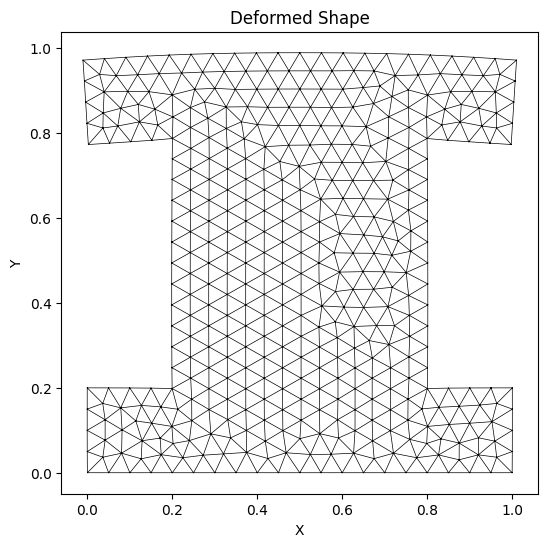

In [ ]:
plt.figure(figsize=(7,6))
plt.triplot(x_def, y_def, elements, color='black', linewidth=0.5)
plt.gca().set_aspect('equal')
plt.title("Deformed Shape")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

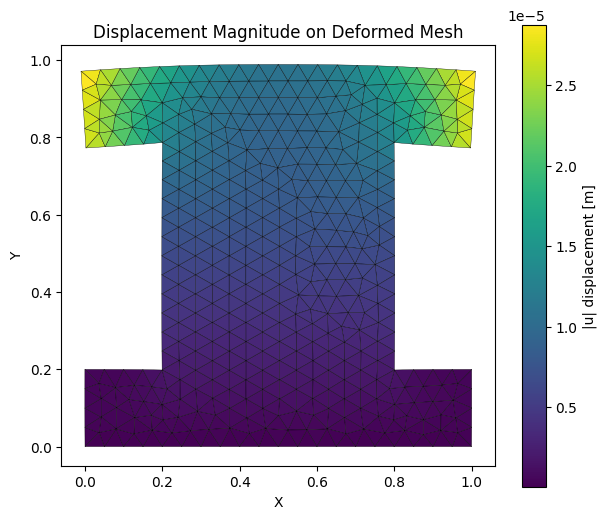

In [ ]:
plt.figure(figsize=(7,6))

tpc1 = plt.tripcolor(
    x_def, y_def, disp_mag,                        # Pass nodal displacement magnitude as the coloring data (C)
    triangles=elements,                            # Explicitly specify the triangle connectivity
    edgecolors='k',
    cmap='viridis'
)

plt.colorbar(tpc1, label="|u| displacement [m]")
plt.gca().set_aspect('equal')
plt.title("Displacement Magnitude on Deformed Mesh")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

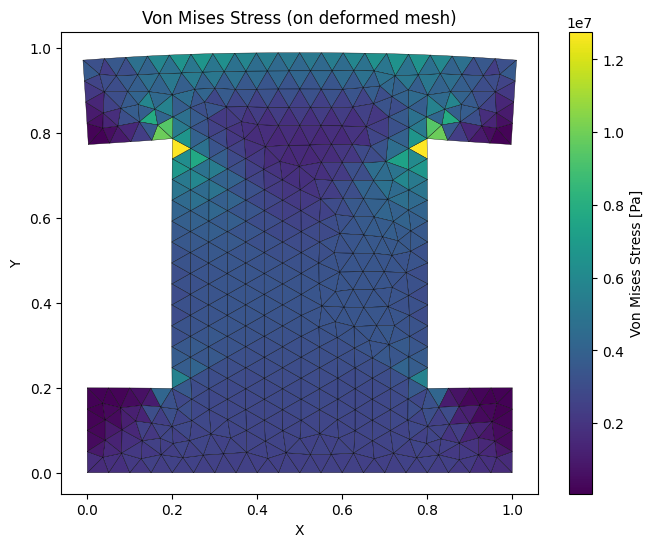

In [ ]:
# ------------------------------------------------------------
# Von Mises plot on deformed mesh
# ------------------------------------------------------------
plt.figure(figsize=(8, 6))

tpc2 = plt.tripcolor(
    x_def, y_def, elements,
    facecolors=von_mises,
    cmap='viridis',
    edgecolors='k'
)

plt.colorbar(tpc2, label='Von Mises Stress [Pa]')
plt.gca().set_aspect('equal')
plt.title('Von Mises Stress (on deformed mesh)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()